In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image

pal = sns.color_palette()
plt.style.use('ggplot')

### Business / Policy Question
---

Migration is a high in the political and policy agenda. Can we predict the next migration wave?

### User
---

World Bank and policy makers of both countries of origin and destination

### Objective
---

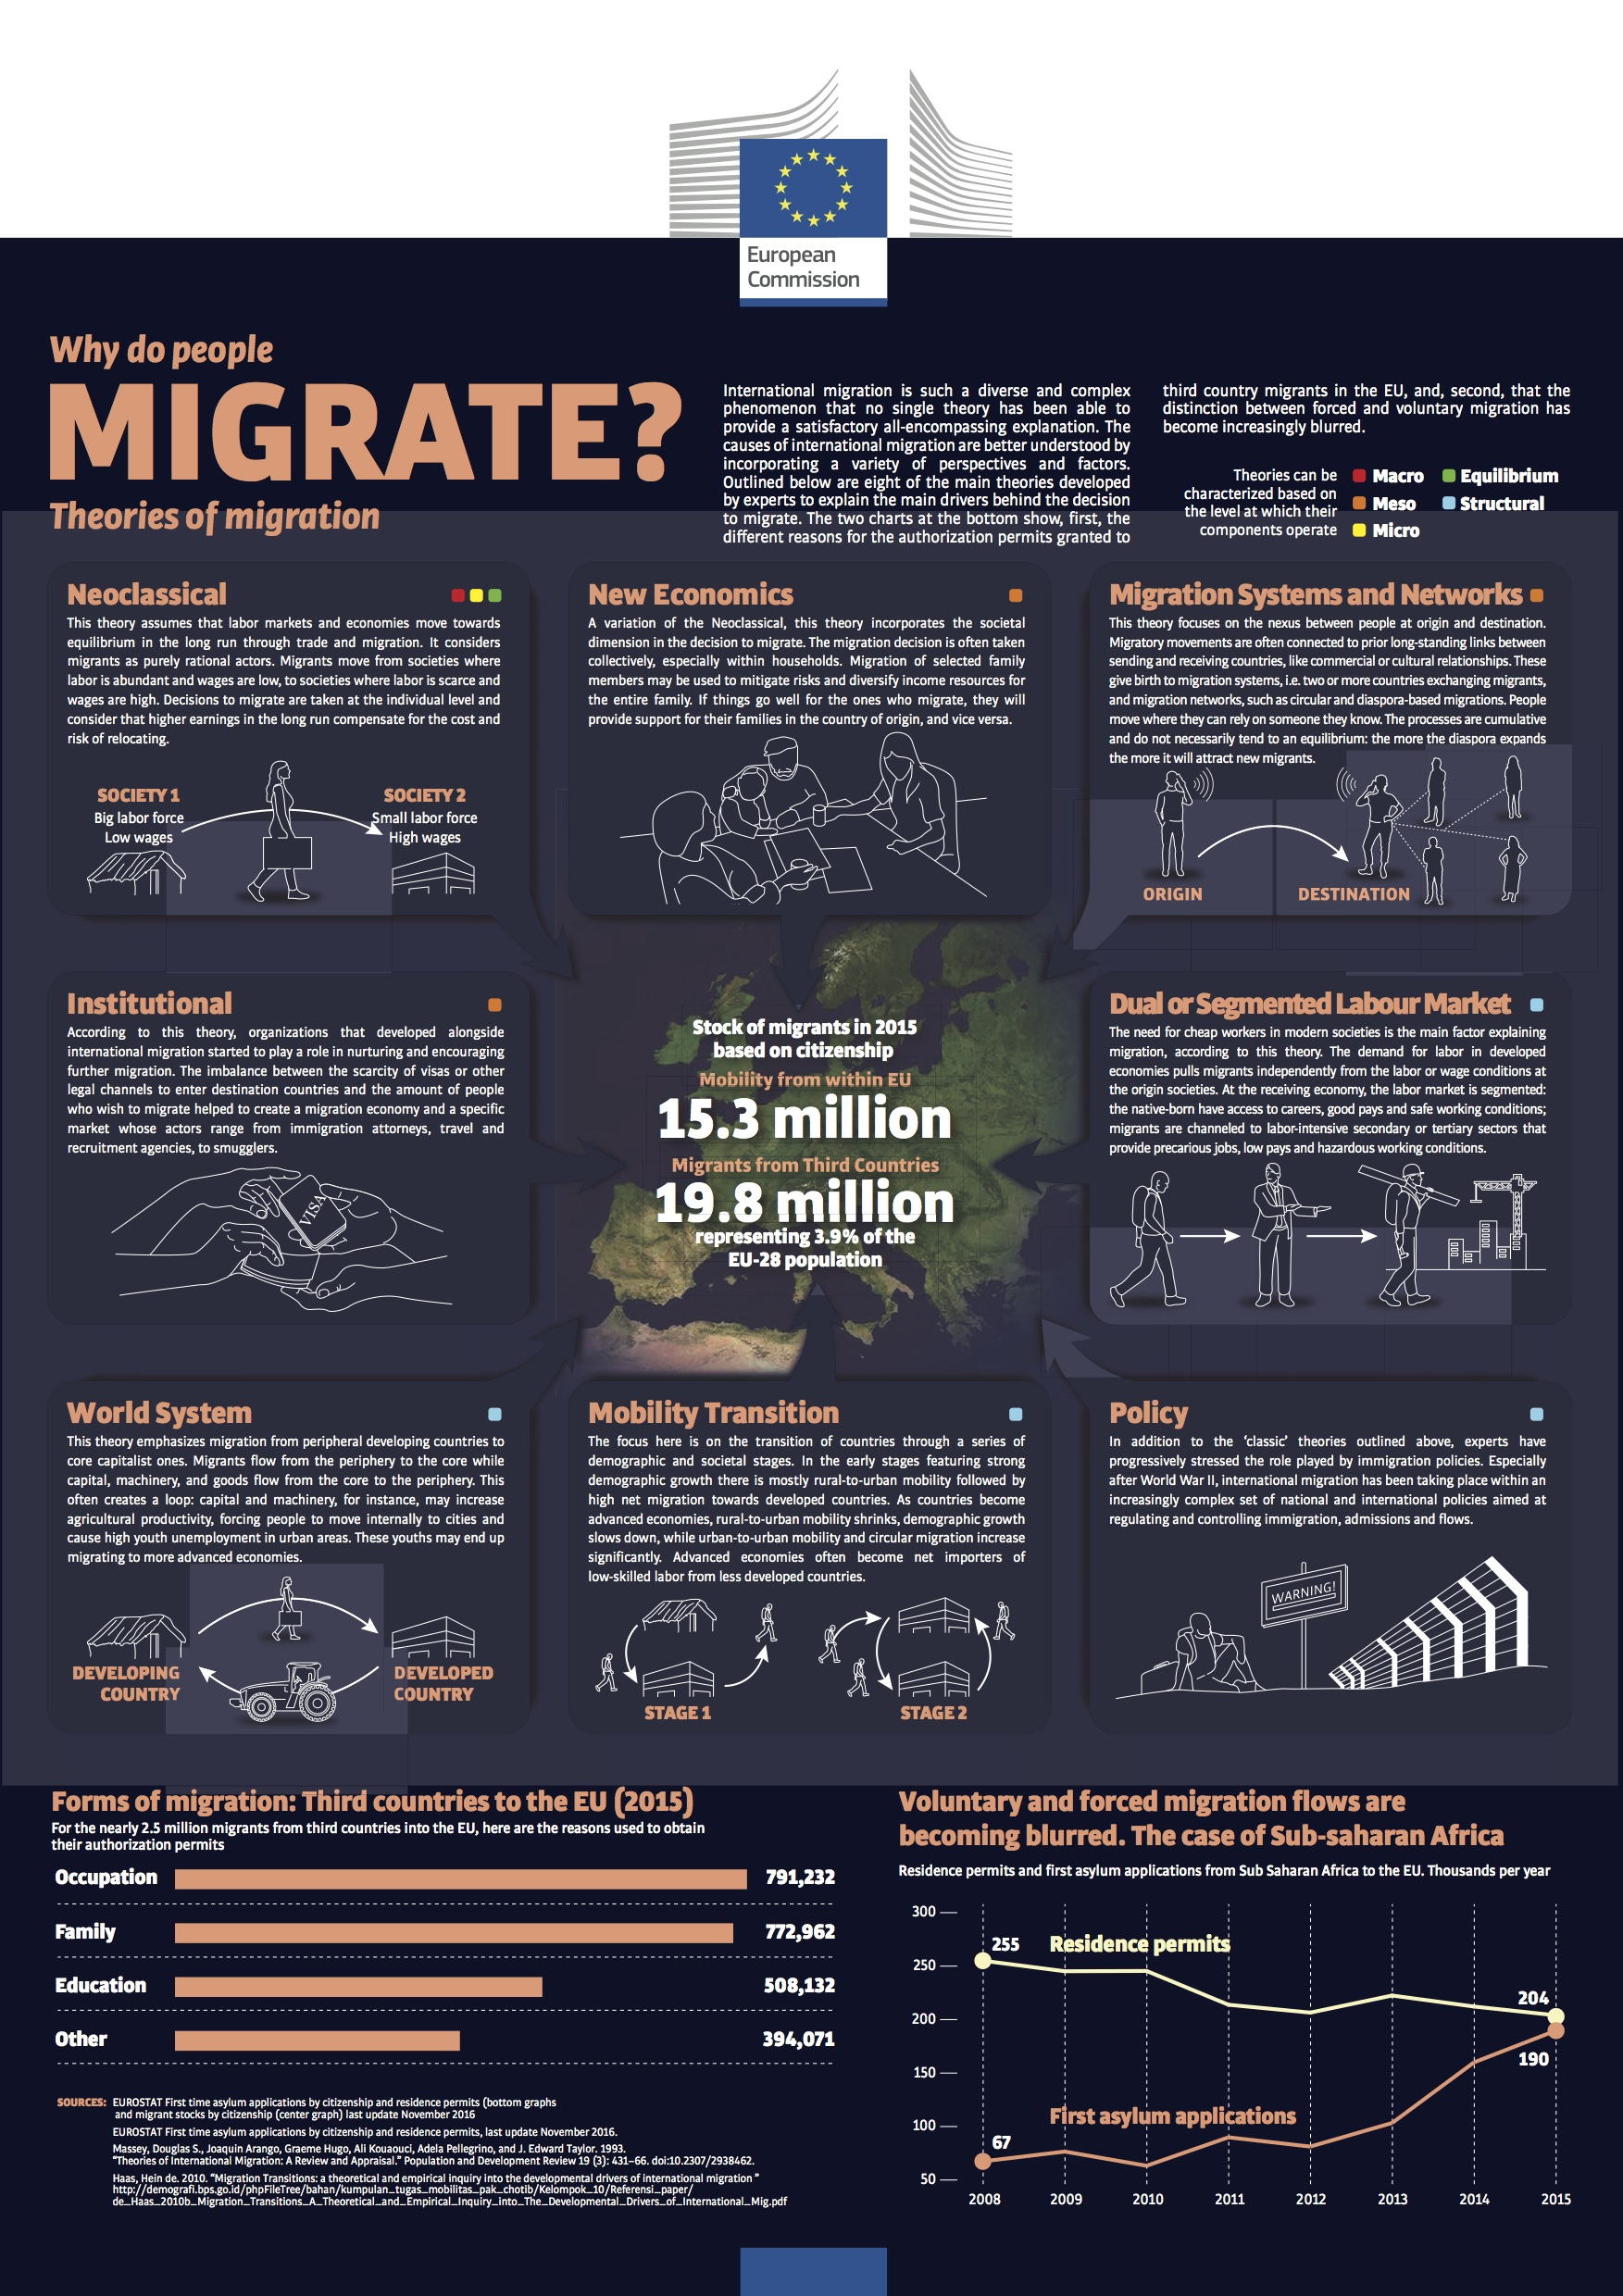

In [7]:
Image("figures/theoriesofmigration.jpg",width=900)

Identify a predictive model migration fluxes, based on existing indicators produced or collected by the World Bank. 


### Data availability
___

Data are free and available at http://databank.worldbank.org/data/home.aspx

### Load and inspect data

In [3]:
# load migration data
df_migr_raw = pd.read_csv('data/migration_data.csv')

In [4]:
df_migr_raw.head()

,Country Origin Name,Country Origin Code,Migration by Gender Name,Migration by Gender Code,Country Dest Name,Country Dest Code,1960 [1960],1970 [1970],1980 [1980],1990 [1990],2000 [2000]
0,Afghanistan,AFG,Female,FEM,Afghanistan,AFG,0,0,0,0,0
1,Afghanistan,AFG,Female,FEM,Albania,ALB,0,0,0,0,0
2,Afghanistan,AFG,Female,FEM,Algeria,DZA,22,8,6,5,4
3,Afghanistan,AFG,Female,FEM,American Samoa,ASM,0,0,0,0,0
4,Afghanistan,AFG,Female,FEM,Andorra,AND,0,0,0,2,3


The table presents migration flows in terms of number of people, by 
1. Country of Origin
2. Gender
3. Country of Destination
4. Decade, from 1960 to 2000

We now select the relevant columns, rename them, and rearrange the database. Specifically, we will move the decade columns as entry, suc that each row is representative of a single observation.

In [5]:
df_migr = df_migr_raw[['Country Origin Name', 'Migration by Gender Code', 'Country Dest Name', 
             '1960 [1960]', '1970 [1970]', '1980 [1980]', '1990 [1990]','2000 [2000]']]
df_migr.columns=['Origin','Gender','Destination','1960','1970','1980','1990','2000']

In [6]:
# rearrange data
df_migr_m = df_migr.melt(id_vars=['Origin','Gender','Destination'],var_name='Year')
df_migr_m['Year'] = df_migr_m['Year'].astype('int64')

We focus on the total migration, i.e. at this stage we do not consider the gender issue.

In [7]:
df_migr_tot = df_migr_m[df_migr_m['Gender']=='TOT']
del df_migr_tot['Gender']

### Analysis of emigration
We first analyze the driving forces for emigration, not considering the destination country

In [8]:
df_migr_tot.value = pd.to_numeric(df_migr_tot.value, errors='coerce')
emigration = df_migr_tot.groupby(['Origin','Year']).sum().reset_index()
emigration.columns = ['Country', 'Year', 'Emigration, total']
emigration.head()

/Users/lraso/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Country,Year,"Emigration, total"
0,Afghanistan,1960,84039.0
1,Afghanistan,1970,131126.0
2,Afghanistan,1980,373995.0
3,Afghanistan,1990,1054244.0
4,Afghanistan,2000,1179710.0


### Some early data exploration

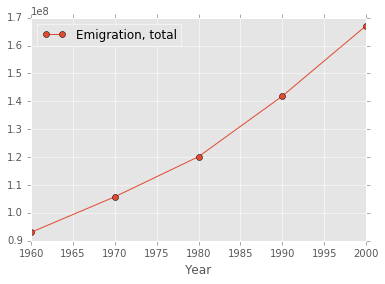

In [33]:
emigration.groupby('Year').sum().plot(marker='o')

The plot above shows how Emigration, in absolute value, has almost doubled in 40 years. 

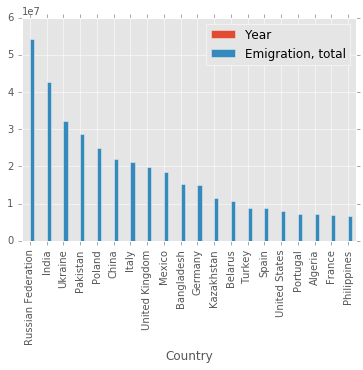

In [10]:
emigration.groupby('Country').sum().sort_values(by='Emigration, total',ascending = False).iloc[0:20].plot(kind='bar')

The plot above shows the countries with the largest absolute emigration flow

This data are not particularly informative, because data-points with large values (big migration flows), dominates their interpretation. A more indicative analysis would require to standardize the data of migration with respect to the country's population. For this reason we use the other World Bank indicators. For this purpose we will use the wbdata module, available at https://github.com/OliverSherouse/wbdata.  

In [11]:
import wbdata

In [12]:
wb_ind_pop = wbdata.search_indicators('Population, Total',source = 2, display=False)
wb_ind_ec = wbdata.search_indicators('GDP per capita',source = 2, display=False)
wb_ind_ec[0]

{'id': 'NY.GDP.PCAP.PP.KD',
 'name': 'GDP per capita, PPP (constant 2011 international $)',
 'source': {'id': '2', 'value': 'World Development Indicators'},
 'sourceNote': "GDP per capita based on purchasing power parity (PPP). PPP GDP is gross domestic product converted to international dollars using purchasing power parity rates. An international dollar has the same purchasing power over GDP as the U.S. dollar has in the United States. GDP at purchaser's prices is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources. Data are in constant 2011 international dollars.",
 'sourceOrganization': 'World Bank, International Comparison Program database.',
 'topics': [{'id': '3', 'value': 'Economy & Growth'}]}

In [13]:
wb_ind_mig = wbdata.search_indicators('International migrant',source = 2, display=False)
wb_ind_mig

[{'id': 'SM.POP.TOTL.ZS',
  'name': 'International migrant stock (% of population)',
  'source': {'id': '2', 'value': 'World Development Indicators'},
  'sourceNote': 'International migrant stock is the number of people born in a country other than that in which they live. It also includes refugees. The data used to estimate the international migrant stock at a particular time are obtained mainly from population censuses. The estimates are derived from the data on foreign-born population--people who have residence in one country but were born in another country. When data on the foreign-born population are not available, data on foreign population--that is, people who are citizens of a country other than the country in which they reside--are used as estimates. After the breakup of the Soviet Union in 1991 people living in one of the newly independent countries who were born in another were classified as international migrants. Estimates of migrant stock in the newly independent states 

In [14]:
indicators = {}

indicators [ wb_ind_pop[0]['id'] ] = wb_ind_pop[0]['name']
indicators [wb_ind_ec[0]['id']] = wb_ind_ec[0]['name']
df = wbdata.get_dataframe(indicators , convert_date=False).reset_index()
df['date'] = df['date'].astype('int64')

In [15]:
def select_years (df, column_dates, years):
    """" Select the years from a larger datasests """

    df_out = pd.DataFrame()
    for year in years:
        df_year = df [df[column_dates]== year]
        df_out = df_out.append(df_year,ignore_index=True)
    return(df_out)    

In [16]:
years_migration = df_migr_m['Year'].unique()
df_date = select_years(df,'date',years_migration)
df_date.columns = ['Country','Year','GDP per capita','Population, total']
df_date.head()

In [17]:
# merge WBI and Migration data
merged = pd.merge(emigration,df_date,how='left',on=['Country','Year'])

In [18]:
merged['Emigration, % pop'] = merged['Emigration, total']/merged['Population, total']*100
merged.head(4)
merged['Country'].unique().shape # number of countries

(232,)

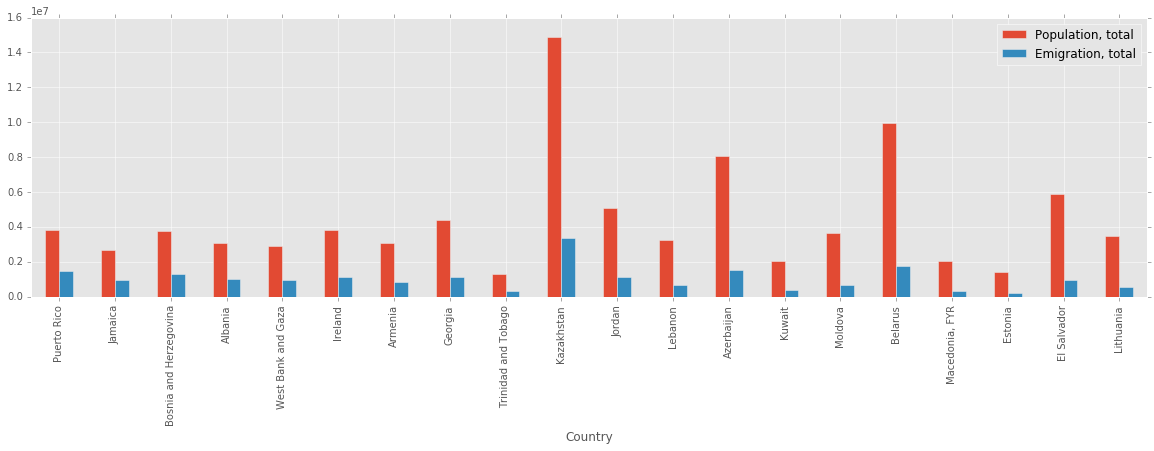

In [19]:
# select sufficiently large country, and show the 
large_emigration_countries = merged[(merged['Population, total']>10**6) & (merged['Year']==2000)]\
.sort_values(by='Emigration, % pop', ascending=False)\
.set_index('Country')

large_emigration_countries[['Population, total','Emigration, total']].iloc[0:20].plot(kind='bar',figsize=(20,5))

(0, 100.0)

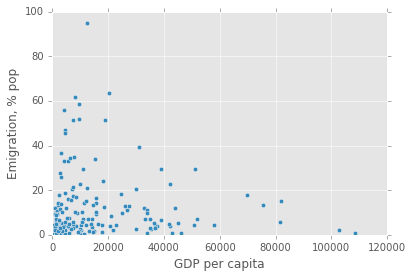

In [20]:
merged[merged['Year']==2000].plot(kind='scatter',x='GDP per capita',y='Emigration, % pop')
plt.xlim(0)
plt.ylim(0)

Economic conditions explain only partially the migration process

In [21]:
df_indicators = pd.read_csv('data/indicators.csv')

In [22]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5656458 entries, 0 to 5656457
Data columns (total 6 columns):
CountryName      object
CountryCode      object
IndicatorName    object
IndicatorCode    object
Year             int64
Value            float64
dtypes: float64(1), int64(1), object(4)
memory usage: 258.9+ MB


In [23]:
del df_indicators['CountryCode']
del df_indicators['IndicatorCode']

In [24]:
# select relevant year
years_migr_int = [int(year) for year in years_migration]
df_indicators_years = select_years (df_indicators, 'Year',years_migr_int )
df_indicators_years.columns = ['Country','Indicator','Year','Value']
df_indicators_years.head()

,Country,Indicator,Year,Value
0,Arab World,"Adolescent fertility rate (births per 1,000 wo...",1960,1.335609e+02
1,Arab World,Age dependency ratio (% of working-age populat...,1960,8.779760e+01
2,Arab World,"Age dependency ratio, old (% of working-age po...",1960,6.634579e+00
3,Arab World,"Age dependency ratio, young (% of working-age ...",1960,8.102333e+01
4,Arab World,Arms exports (SIPRI trend indicator values),1960,3.000000e+06


In [25]:
df_indicators_years_pivot = df_indicators_years.pivot_table(index=['Country','Year'],columns='Indicator',values='Value')
df_indicators_years_pivot = df_indicators_years_pivot.reset_index()

In [26]:
# merge data-sets
data_set = emigration.merge(df_indicators_years_pivot,how='left',on=['Country','Year'])


In [27]:
data_set.shape

(1160, 1142)

### Cleaning datasets
The indicator dataset is not ready-to-use. It contains an very large number of missing data. 

(1160,)

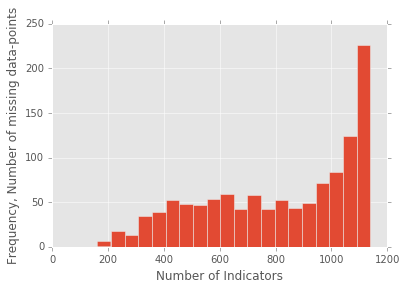

In [28]:
# statistics on missing data

plt.hist(data_set.isnull().sum(1).values,bins=20)
plt.xlabel('Number of Indicators')
plt.ylabel('Frequency, Number of missing data-points')
data_set.isnull().sum(1).shape

There are data-points that are poorly populated. These should also be removed.

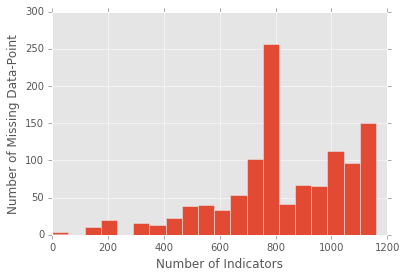

In [29]:
plt.hist(data_set.isnull().sum(0),bins=20)
plt.ylabel('Number of Missing Data-Point')
plt.xlabel('Number of Indicators')

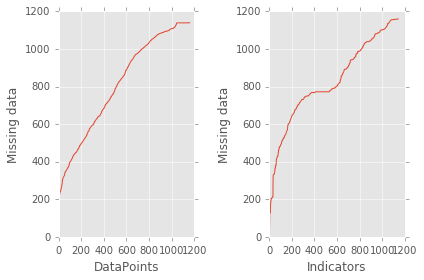

In [30]:
plt.subplot(121)
miss_data = data_set.isnull().sum(1).sort_values().values
plt.plot(miss_data);plt.xlabel('DataPoints');plt.ylabel('Missing data')
plt.subplot(122)
miss_ind = data_set.isnull().sum().sort_values().values
plt.plot(miss_ind);plt.xlabel('Indicators');plt.ylabel('Missing data')
plt.tight_layout()



The function smart_cut drops rows and columns with a large number of missing data, until a small percentage of missing value, considered acceptable is reached. The wheight modulates the importance of keeping columns. Since we prefer to have more datapoints than indicators, we will set this parameter at a value lower than 1 (more weights to data-points) 

In [31]:
from migration import smart_cut, order_by_nan,sel_regressor    

SyntaxError: invalid syntax (migration.py, line 58)

In [ ]:
threshold = 0.05
weight_ind = 0.1
data_set_cut = smart_cut(data_set,threshold,weight_ind)

In [ ]:
print('Using these parameters, we keep ' + str(data_set_cut.shape[0]) + ' datapoints and '+ 
      str(data_set_cut.shape[1]-2) + ' indicators')

Below the list of retained indicator

In [ ]:
print(data_set_cut.columns[1:].values)

We now fill the remaining missing data with the average of its columns. There are probably better way to do this, but we will explore them in a second stage. 

In [ ]:
data_set_cut = data_set_cut.fillna(data_set_cut.mean())

___
Let's check the consistency, presence of outliers, etc

In [34]:
data_set_cut[data_set_cut>10**15].any()

NameError: name 'data_set_cut' is not defined

In [ ]:
np.log(data_set_cut['Gross national expenditure (current LCU)'])

We now have a clean dataset, to be used for training a model

In [ ]:
sns.distplot(data_set_cut['Emigration, total'],rug=True)
plt.xlim(0)

Much skewed distribution. A model using these data would be dominated by the few extreme values. We transform the data, log ()

In [ ]:
sns.distplot(np.log(data_set_cut['Emigration, total']))

Much better shaped distribution. 

In [ ]:
f = lambda x: x 
f = np.log
plt.scatter(f(data_set_cut['International migrant stock, total']),f(data_set_cut['Emigration, total']))

In [ ]:
plt.figure(figsize=(30,30))
sns.heatmap(data_set_cut.corr(),center=0)

In [ ]:
plt.figure(figsize=(30,30))
sns.heatmap(np.log(data_set_cut[data_set_cut.columns[2:]]).corr(),center=0)

### Feature Engineering

In [ ]:
# add feature Emigration t-1 (previous)

Transform both input and output.
where
* $k_i = \exp (\alpha_i)$
* $y = log (E)$
* $x_i = log (I_i)$


so that the model: 

---
$y = \alpha_0 + \alpha_1 \cdot x_1 + \alpha_2 \cdot x_2 + \alpha_3 \cdot x_3  \ldots$   (multiplicative factors)



$\ldots \alpha_4 x_4 + \alpha_5 x_5$ (additive factors)

---
It is equivalent to

---
$\log E = \alpha_0  + \alpha_1 \log {I_1} + \alpha_2 \log {I_2} + \alpha_3 \log {I_3} + \ldots$ 

$\ldots + \alpha_4 I_4 + \alpha_5 I_5$

---

hence to a multiplicative model, as below

___
$E = k_0 \cdot {I_1}^{\alpha_1}\cdot {I_2}^{\alpha_2}\cdot {I_3}^{\alpha_3} \cdot \ldots$

$\ldots \cdot k_4 \exp (I_4) \cdot k_5 \exp(I_5) $

---

p.s. there are few additive indicators

### Model Identification

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [ ]:
def sel_regressor(df,col_target):
    """Given a dataframe and the target column, create matrix of regressors X and target y"""
    
    y = df[col_target].values.astype(float)
    X = df.drop(col_target,axis=1).values.astype(float)
    return X,y

In [ ]:
X,y = sel_regressor(data_set_cut.drop('Country',axis=1),'Emigration, total')
X.shape

In [ ]:
# Preprocessing X,y

In [ ]:
X_scaled = preprocessing.robust_scale(X)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [ ]:
model = LassoCV(0.01)

In [ ]:
model.fit(X,y)

In [ ]:
print(model.coef_)